# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
xgb.__version__

'0.90'

In [3]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20191218/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200309/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200311/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200312/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200324/'

os.system("mkdir -p "+ plotDir)
os.system("mkdir -p "+ plotDir + "training")
os.system("mkdir -p "+ plotDir + "results")
os.system("mkdir -p "+ plotDir + "scores")
os.system("mkdir -p "+ plotDir + "variables")

0

In [4]:
test_name = 'xgb_HH200_unmatch_vs_fixBKG_ebBDT'
# test_name = 'xgb_HH200_unmatch_vs_BKG_ebBDT'
# test_name = 'xgb_HH200_vs_BKG_ebBDT'


In [44]:
# signal and bkg file normalized
dataDir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/skimmed/'
#sig 
signalFileName = dataDir + 'skim_sig_hh200_unmatch.root'
# signalFileName = dataDir + 'skim_sig_hh200.root'
# signalFileName = dataDir + 'out_sig.root'
# signalFileName = dataDir + 'bdt_hh_sig.root'
signalFile = rt.TFile(signalFileName)
signalTree = signalFile.Get('BDT_Tree')
# signalTree = signalFile.Get('SusyLLPTree')
signalEvents = lumi_sf_sig*signalTree.GetEntries()

#bkg
# bkgFileName    = dataDir + 'skim_qcd_ht_all.root'
# bkgFileName    = dataDir + 'skim_qcd_ht_500_700.root'
# bkgFileName    = dataDir + 'skim_bkg_qcd_wjets_tjets.root'
bkgFileName    = dataDir + 'skim_bkg_norm_all.root'
# bkgFileName    = dataDir + 'skim_bkg_all.root'
# bkgFileName    = dataDir + 'out_bkg.root'
# bkgFileName    = dataDir + 'bdt_qcd_bkg.root'
bkgFile = rt.TFile(bkgFileName)
bkgTree = bkgFile.Get('BDT_Tree')
# bkgTree = bkgFile.Get('SusyLLPTree')
bkgEvents = lumi_sf_bkg*bkgTree.GetEntries()

print('[INFO]: S =' + str(signalEvents) + '; B =' + str(bkgEvents) +"; S/sqrt(B) = " + str(signalEvents/math.sqrt(bkgEvents)))

[INFO]: S =407712.0; B =1014314024.0; S/sqrt(B) = 12.801689194178508


In [132]:
## print check
# root_dir = uproot.open(signalFileName) 
# tree = root_dir['BDT_Tree']
# # tree = root_dir['SusyLLPTree']
# jet_amax = tree['jetGammaMax_ET'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetTime'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetChargedHadronEnergyFraction'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetMinDeltaRPVTracks'].array()
# print(jet_amax[:10])
# jet_amax = tree['jet_sig_et1'].array()
# print(jet_amax[:10])
# jet_amax = tree['jet_sig_et2'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetPt'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetTime'].array()
# print(jet_amax[:10])
# jet_amax = tree['weight'].array()
# print(jet_amax[:10])
# jet_amax = tree['flat_w'].array()
# print(jet_amax[:10])


In [133]:
## print check bkg
# root_dir = uproot.open(bkgFileName) 
# tree = root_dir['SusyLLPTree']
# jet_amax = tree['jetGammaMax_ET'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetTime'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetChargedHadronEnergyFraction'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetMinDeltaRPVTracks'].array()
# print(jet_amax[:10])
# jet_amax = tree['jet_sig_et1'].array()
# print(jet_amax[:10])
# jet_amax = tree['jet_sig_et2'].array()
# print(jet_amax[:10])
# jet_amax = tree['jetPt'].array()
# print(len(jet_amax))
# print(jet_amax[:10])
# jet_amax = tree['jetTime'].array()
# print(len(jet_amax[0]))
# print(len(jet_amax))
# print(jet_amax[:10])
# jet_amax = tree['weight'].array()
# print(jet_amax[:10])
# print(np.unique(jet_amax))
# print(len(jet_amax[jet_amax==6.3736355e-03]))
# print(len(jet_amax[jet_amax==3.2551792e-02]))
# jet_amax = tree['flat_w'].array()
# print(jet_amax[:10])
# print(len(jet_amax))
# print(len(jet_amax[0]))


In [5]:
#variables
variables = [
#         ['met', 'met', 'met', 100, 0, 1000],
#         ['jetPt', 'jetPt', 'jetPt', 50, 0, 1000],
#         ['jetTime', 'jetTime', 'jetTime', 50, -10, 20],
#         ['jetChargedHadronEnergyFraction', 'jetChargedHadronEnergyFraction', 'CHEF', 50, 0, 1],
#         ['jetNeutralHadronEnergyFraction', 'jetNeutralHadronEnergyFraction', 'NHEF', 50, 0, 1],
#         ['jetChargedEMEnergyFraction', 'jetChargedEMEnergyFraction', 'CEMEF', 50, 0, 1],
#         ['jetNeutralEMEnergyFraction', 'jetNeutralEMEnergyFraction', 'NEMEF', 50, 0, 1],
#         ['jetGammaMax_ET', 'jetGammaMax_ET', 'jetGammaMax_ET', 50, 0, 1],
#         ['jetMinDeltaRPVTracks', 'jetMinDeltaRPVTracks', 'jetMinDeltaRPVTracks', 50, 0, 1],
#         ['jet_sig_et1', 'jet_sig_et1', 'jet_sig_et1', 50, 0, 0.3],
#         ['jet_sig_et1', 'jet_sig_et2', 'jet_sig_et2', 50, 0, 0.3],
        ['jetTime_', 'jetTime', 'jetTime', 50, -10, 20],
        ['jetChargedHadronEnergyFraction_', 'jetChargedHadronEnergyFraction_', 'CHEF', 50, 0, 1],
        ['jetNeutralHadronEnergyFraction_', 'jetNeutralHadronEnergyFraction_', 'NHEF', 50, 0, 1],
        ['jetChargedEMEnergyFraction_', 'jetChargedEMEnergyFraction_', 'CEMEF', 50, 0, 1],
        ['jetNeutralEMEnergyFraction_', 'jetNeutralEMEnergyFraction_', 'NEMEF', 50, 0, 1],
        ['jetGammaMax_ET_', 'jetGammaMax_ET_', 'jetGammaMax_ET', 50, 0, 1],
        ['jetMinDeltaRPVTracks_', 'jetMinDeltaRPVTracks_', 'jetMinDeltaRPVTracks', 50, 0, 1],
            ]


In [46]:
##Getting ROOT files into pandas
# df_signal = uproot.open(signalFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)
# df_bkg = uproot.open(bkgFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)
df_signal = uproot.open(signalFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)
df_bkg = uproot.open(bkgFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)


In [47]:
#weight
#sig
sig_root_dir = uproot.open(signalFileName) 
sig_tree = sig_root_dir['BDT_Tree']
# sig_tree = sig_root_dir['SusyLLPTree']
# #branches
# sig_w = sig_tree['weight'].array() 
# sig_jet_pt = sig_tree['jetPt'].array()
sig_w = sig_tree['weight_'].array() 
sig_jet_pt = sig_tree['jetPt_'].array()
from itertools import chain 
sig_flat_w = [np.array([x]*len(y)) for x,y in zip(sig_w,sig_jet_pt)]
sig_flat_w = list(chain.from_iterable(sig_flat_w))
sig_flat_w = [x*137000 for x in sig_flat_w]
# sig_w = sig_tree['flat_w'].array().flatten()
# bkg
bkg_root_dir = uproot.open(bkgFileName) 
bkg_tree = bkg_root_dir['BDT_Tree']
# bkg_tree = bkg_root_dir['SusyLLPTree']
# #branches
# bkg_w = bkg_tree['weight'].array() 
# bkg_jet_pt = bkg_tree['jetPt'].array()
bkg_w = bkg_tree['weight_'].array() 
bkg_jet_pt = bkg_tree['jetPt_'].array()
bkg_flat_w = [np.array([x]*len(y)) for x,y in zip(bkg_w,bkg_jet_pt)]
bkg_flat_w = list(chain.from_iterable(bkg_flat_w)) 
bkg_flat_w = [x*137000 for x in bkg_flat_w]
# bkg_w = bkg_tree['flat_w'].array().flatten()
# sample weight
sample_w = np.concatenate([sig_flat_w,bkg_flat_w])
# sample_w = np.concatenate([sig_w,bkg_w])
print(sig_flat_w[0])
print(())
print(len(sig_flat_w))
print(len(sig_w))
print(len(sig_jet_pt))
print(len(sig_jet_pt.flatten()))


1.1118959409941453
()
5785
2976
2976
5785


In [79]:
# #remake new sig root file
# sig_root_dir = uproot.open(signalFileName) 
# sig_tree = sig_root_dir['SusyLLPTree']
# #branches
# sig_w = sig_tree['weight'].array()
# sig_jet_pt = sig_tree['jetPt'].array()
# sig_jet_t = sig_tree['jetTime'].array()
# sig_jet_chef = sig_tree['jetChargedHadronEnergyFraction'].array()
# sig_jet_tmf = sig_tree['jetGammaMax_ET'].array()
# sig_jet_dr = sig_tree['jetMinDeltaRPVTracks'].array()
# #flatten
# from itertools import chain 
# sig_flat_w = [np.array([x]*len(y)) for x,y in zip(sig_w,sig_jet_pt)]
# sig_flat_w = list(chain.from_iterable(sig_flat_w)) 
# sig_flat_pt = list(chain.from_iterable(sig_jet_pt)) 
# sig_flat_t = list(chain.from_iterable(sig_jet_t)) 
# sig_flat_chef = list(chain.from_iterable(sig_jet_chef)) 
# sig_flat_tmf = list(chain.from_iterable(sig_jet_tmf)) 
# sig_flat_dr = list(chain.from_iterable(sig_jet_dr)) 
# #new tree
# # print(len(sig_w))
# # print(len(sig_jet_t))
# # print(len(sig_jet_t.flatten()))
# # print(len(sig_flat_w))
# # print(len(sig_flat_t))
# # print(type(sig_flat_w))
# # print(type(sig_flat_t))
# # print(type(sig_flat_pt))
# # print(type(np.array(sig_flat_pt)))
# new_sig_tree_array = np.stack((sig_flat_w,sig_flat_pt,sig_flat_t,sig_flat_chef,sig_flat_tmf,sig_flat_dr),axis=-1)
# # print(type(new_sig_tree_array))
# # print(new_sig_tree_array[0])
# # print(type(new_sig_tree_array[0]))

# # print(sig_flat_w[0])
# # print(sig_flat_t[0])
# # print(type(new_sig_tree_array))
# # print(len(new_sig_tree_array))
# # print(len(new_sig_tree_array[0]))
# # print(new_sig_tree_array[0])

# h_new_sig_tree_array = [np.array(x) for x in new_sig_tree_array]
# print(type(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array[0]))
# print(h_new_sig_tree_array[0])


# h_new_sig_tree_array = np.array(h_new_sig_tree_array,
# # h_new_sig_tree_array = np.array([np.array(sig_flat_w),np.array(sig_flat_pt),np.array(sig_flat_t),np.array(sig_flat_chef),np.array(sig_flat_tmf),np.array(sig_flat_dr)], 
#                               dtype=[('weight', np.float32),
#                                      ('jetPt', np.float32),
#                                      ('jetTime', np.float32),
#                                      ('jetChargedHadronEnergyFraction', np.float32),
#                                      ('jetGammaMax_ET', np.float32),
#                                      ('jetMinDeltaRPVTracks', np.float32),
#                                     ]
#                                )

# print(type(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array))
# print(len(h_new_sig_tree_array[0]))
# print(h_new_sig_tree_array[0])

# # from root_numpy import array2root, root2array, array2tree
# # new_sig = array2root(new_tree_array, 'new_sig.root', new_sig_tree, mode='recreate') 
# # import root_numpy as rtnp
# new_sig_tree = array2tree(h_new_sig_tree_array)
# new_sig_tree.Scan()

In [80]:
# from root_numpy import array2tree
# import numpy as np
# a = np.array([(1, 2.5, 3.4),
#                (4, 5, 6.8)],
#               dtype=[('a', np.int32),
#                      ('b', np.float32),
#                      ('c', np.float64)])
# print(a)
# print(type(a))
# print(a[0])
# print(type(a[0]))
# a_tree = array2tree(a)
# a_tree.Scan()

In [81]:
# #remake new bkg root file
# bkg_root_dir = uproot.open(bkgFileName) 
# bkg_tree = bkg_root_dir['SusyLLPTree']
# #branches
# bkg_w = bkg_tree['weight'].array()
# bkg_jet_pt = bkg_tree['jetPt'].array()
# bkg_jet_t = bkg_tree['jetTime'].array()
# bkg_jet_chef = bkg_tree['jetChargedHadronEnergyFraction'].array()
# bkg_jet_tmf = bkg_tree['jetGammaMax_ET'].array()
# bkg_jet_dr = bkg_tree['jetMinDeltaRPVTracks'].array()
# #flatten
# from itertools import chain 
# bkg_flat_w = [np.array([x]*len(y)) for x,y in zip(bkg_w,bkg_jet_pt)]
# bkg_flat_w = list(chain.from_iterable(bkg_flat_w)) 
# bkg_flat_pt = list(chain.from_iterable(bkg_jet_pt)) 
# bkg_flat_t = list(chain.from_iterable(bkg_jet_t)) 
# bkg_flat_chef = list(chain.from_iterable(bkg_jet_chef)) 
# bkg_flat_tmf = list(chain.from_iterable(bkg_jet_tmf)) 
# bkg_flat_dr = list(chain.from_iterable(bkg_jet_dr)) 
# #new tree
# print(len(bkg_w))
# print(len(bkg_jet_t))
# print(len(bkg_jet_t.flatten()))
# print(len(bkg_flat_w))
# print(len(bkg_flat_t))
# new_bkg_tree_array = np.stack((bkg_flat_w,bkg_flat_pt,bkg_flat_t,bkg_flat_chef,bkg_flat_tmf,bkg_flat_dr),axis=-1)

# print(bkg_flat_w[0])
# print(bkg_flat_t[0])
# print(len(new_bkg_tree_array))
# print(len(new_bkg_tree_array[0]))
# print(new_bkg_tree_array[0])

In [48]:
## change nan to -999
df_signal = df_signal.fillna(-999)
df_bkg = df_bkg.fillna(-999)


In [48]:
# ##Getting NEW ARRAY files into pandas
# df_signal = uproot.open(signalFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)
# df_bkg = uproot.open(bkgFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)

In [49]:
##Getting a numpy array out of two pandas data frame

#getting a numpy array from two pandas data frames
x = np.concatenate([df_bkg.values,df_signal.values])
#creating numpy array for target variables
y = np.concatenate([np.zeros(len(df_bkg)),
np.ones(len(df_signal))])

In [50]:
###plot correlation
file_sig = rt.TFile(signalFileName)
# tree_sig = file_sig.Get("SusyLLPTree")
tree_sig = file_sig.Get("BDT_Tree")
file_bkg = rt.TFile(bkgFileName)
# tree_bkg = file_sig.Get("SusyLLPTree")
tree_bkg = file_sig.Get("BDT_Tree")
h2_corr_sig = rt.TH2F("h2_corr_sig", "h2_corr_sig", len(variables), 0, len(variables), len(variables), 0, len(variables))
h2_corr_bkg = rt.TH2F("h2_corr_bkg", "h2_corr_bkg", len(variables), 0, len(variables), len(variables), 0, len(variables))

for idx1 in range(len(variables)):
        for idx2 in range(len(variables)):
                tree_sig.Draw(variables[idx1][0]+":"+variables[idx2][0]+">>temp_sig")
                tree_bkg.Draw(variables[idx1][0]+":"+variables[idx2][0]+">>temp_bkg")
                sig_hist = rt.gDirectory.Get('temp_sig')
                h2_corr_sig.SetBinContent(idx1+1, idx2+1, sig_hist.GetCorrelationFactor())
                bkg_hist = rt.gDirectory.Get('temp_bkg')
                h2_corr_bkg.SetBinContent(idx1+1, idx2+1, bkg_hist.GetCorrelationFactor())
                rt.gDirectory.Delete('temp_sig')
                rt.gDirectory.Delete('temp_bkg')
h2_corr_sig.GetXaxis().SetLabelSize(0.03)
h2_corr_sig.GetYaxis().SetLabelSize(0.03)
h2_corr_sig.GetZaxis().SetLabelSize(0.03)
h2_corr_bkg.GetXaxis().SetLabelSize(0.03)
h2_corr_bkg.GetYaxis().SetLabelSize(0.03)
h2_corr_bkg.GetZaxis().SetLabelSize(0.03)
h2_corr_sig.GetZaxis().SetRangeUser(-1.0, 1.0)
h2_corr_bkg.GetZaxis().SetRangeUser(-1.0, 1.0)
for idx in range(len(variables)):
        h2_corr_sig.GetXaxis().SetBinLabel(idx+1, variables[idx][1])
        h2_corr_sig.GetYaxis().SetBinLabel(idx+1, variables[idx][1])
        h2_corr_bkg.GetXaxis().SetBinLabel(idx+1, variables[idx][1])
        h2_corr_bkg.GetYaxis().SetBinLabel(idx+1, variables[idx][1])

myC = rt.TCanvas( "myC", "myC", 200, 10, 900, 800 )
myC.SetHighLightColor(2)
myC.SetFillColor(0)
myC.SetBorderMode(0)
myC.SetBorderSize(2)
myC.SetLeftMargin( 0.12 )
myC.SetRightMargin( 0.12 )
myC.SetBottomMargin( 0.12 )
myC.SetTopMargin( 0.12 )
myC.SetFrameBorderMode(0)
myC.SetFrameBorderMode(0)

stops = np.array([0.00, 0.34, 0.61, 0.84, 1.00])
red= np.array([0.50, 0.50, 1.00, 1.00, 1.00])
green = np.array([ 0.50, 1.00, 1.00, 0.60, 0.50])
blue = np.array([1.00, 1.00, 0.50, 0.40, 0.50])
rt.TColor.CreateGradientColorTable(len(stops), stops, red, green, blue, 255)
rt.gStyle.SetNumberContours(255)



h2_corr_sig.Draw("COLZTEXT")
h2_corr_sig.SetTitle("")
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_sig.pdf')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_sig.png')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_sig.C')
h2_corr_bkg.Draw("COLZTEXT")
h2_corr_bkg.SetTitle("")
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_bkg.pdf')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_bkg.png')
myC.SaveAs(plotDir+'variables/'+test_name + '_correlation_matrix_bkg.C')
os.system("chmod 755 "+plotDir+"variables/*")


0

Info in <TCanvas::Print>: pdf file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/variables/xgb_HH200_unmatch_vs_fixBKG_ebBDT_correlation_matrix_sig.pdf has been created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/variables/xgb_HH200_unmatch_vs_fixBKG_ebBDT_correlation_matrix_sig.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/variables/xgb_HH200_unmatch_vs_fixBKG_ebBDT_correlation_matrix_sig.C has been generated
Info in <TCanvas::Print>: pdf file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/variables/xgb_HH200_unmatch_vs_fixBKG_ebBDT_correlation_matrix_bkg.pdf has been created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/variables/xgb_HH200_unmatch_vs_fixBKG_ebBDT_correlation_matrix_bkg.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/variables/xgb_HH200_

In [51]:
####Print input variables######
for idx in range(len(variables)):
    print(idx, variables[idx][0])
    print(df_signal[df_signal[variables[idx][0]]>0][variables[idx][0]][:10])


0 jetTime_
entry  subentry
0      0           0.454689
       1           0.018547
       3           0.823035
       4           1.810274
2      0           0.694622
       1           0.955421
3      0           0.024251
4      0           0.047974
       1           0.938995
5      0           0.412542
Name: jetTime_, dtype: float32
1 jetChargedHadronEnergyFraction_
entry  subentry
0      0           0.874350
       1           0.126975
       2           0.410221
       3           0.074458
       4           0.684725
2      0           0.743356
       1           0.021334
3      0           0.804199
4      0           0.859334
       1           0.594239
Name: jetChargedHadronEnergyFraction_, dtype: float32
2 jetNeutralHadronEnergyFraction_
entry  subentry
0      0           0.016502
       1           0.009085
       2           0.118234
       3           0.384236
       4           0.033311
2      0           0.019033
       1           0.425767
3      0           0.075963
4   

0

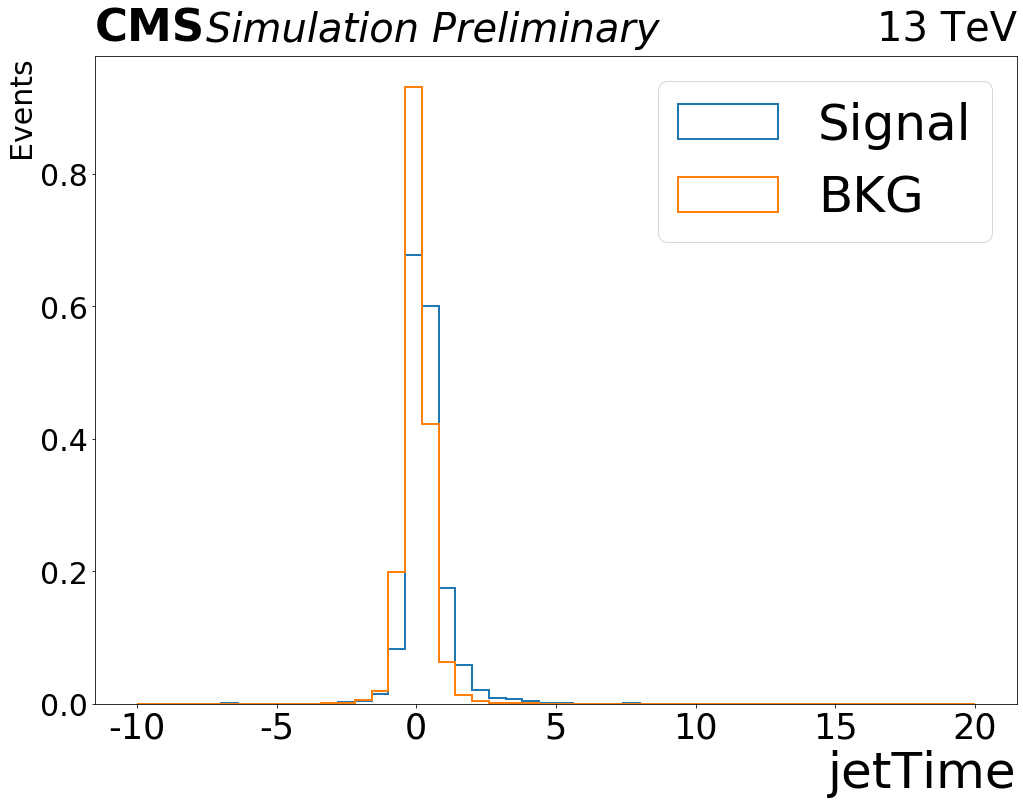

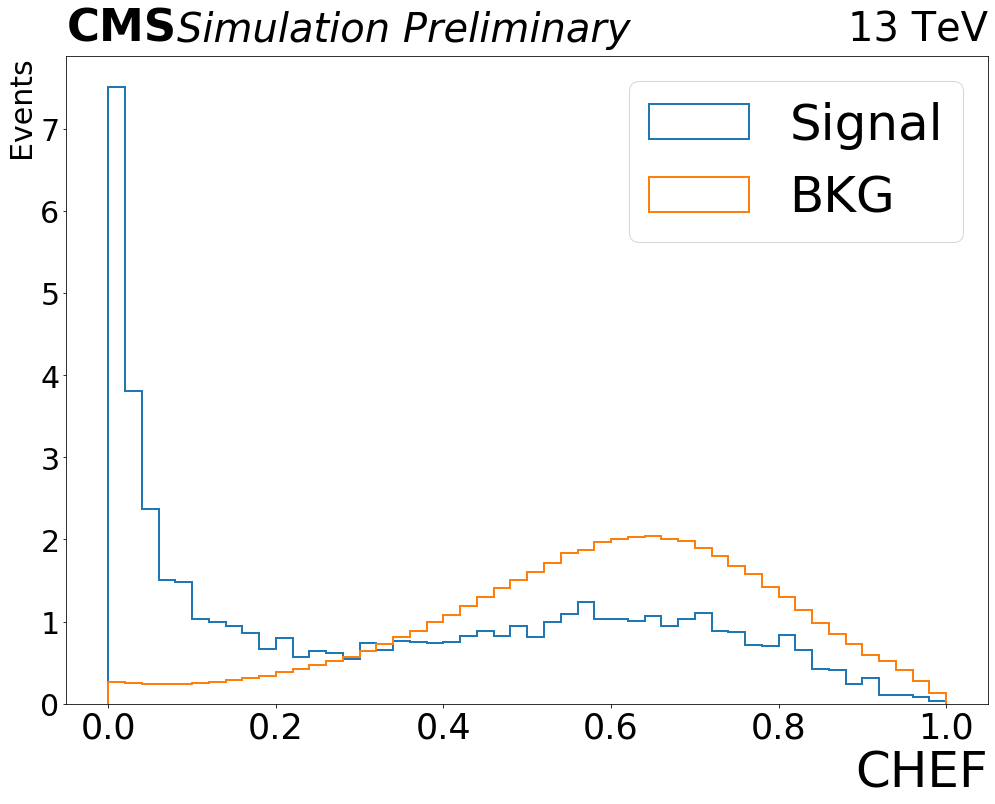

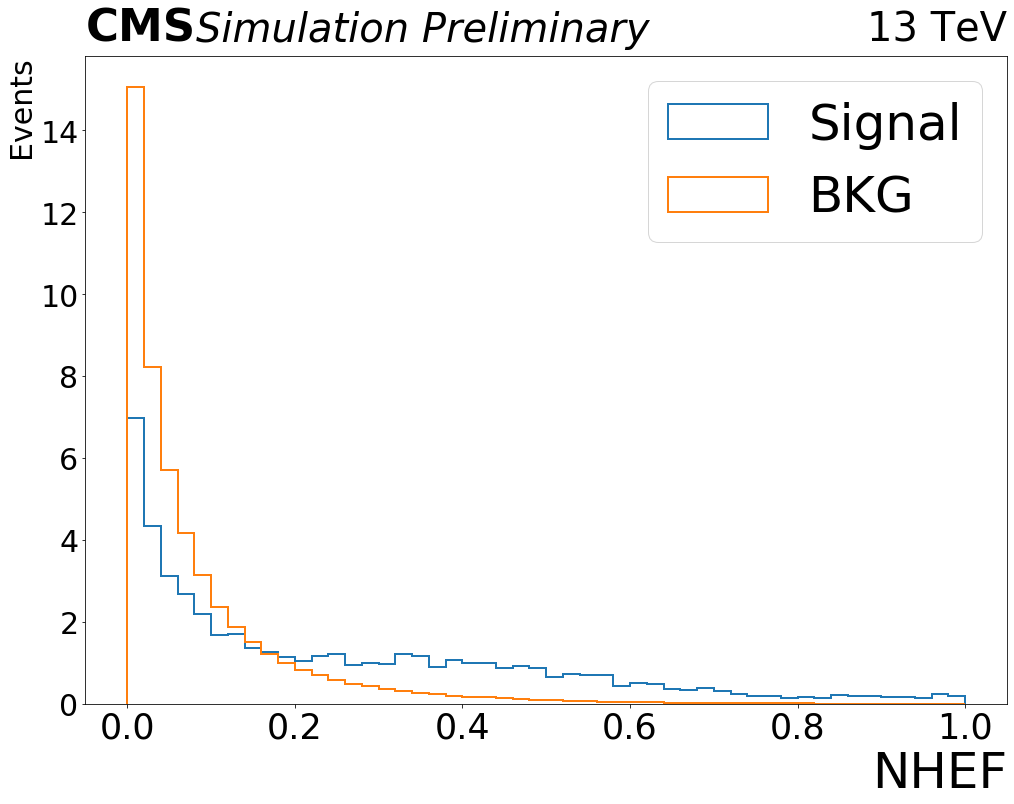

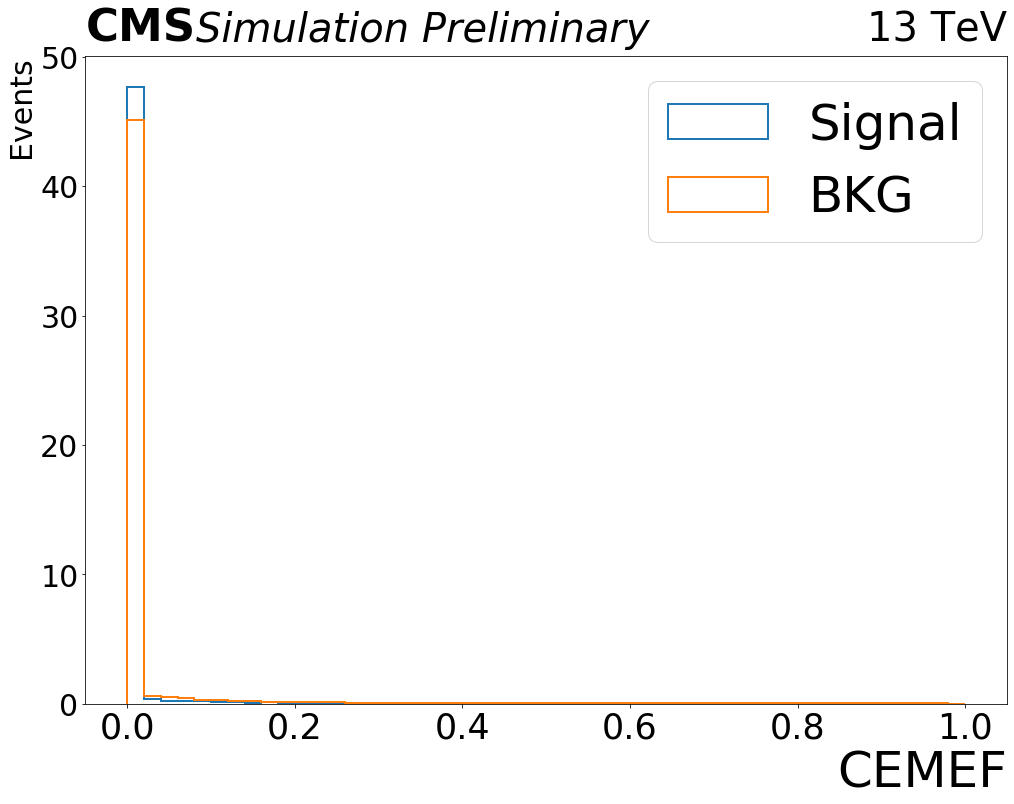

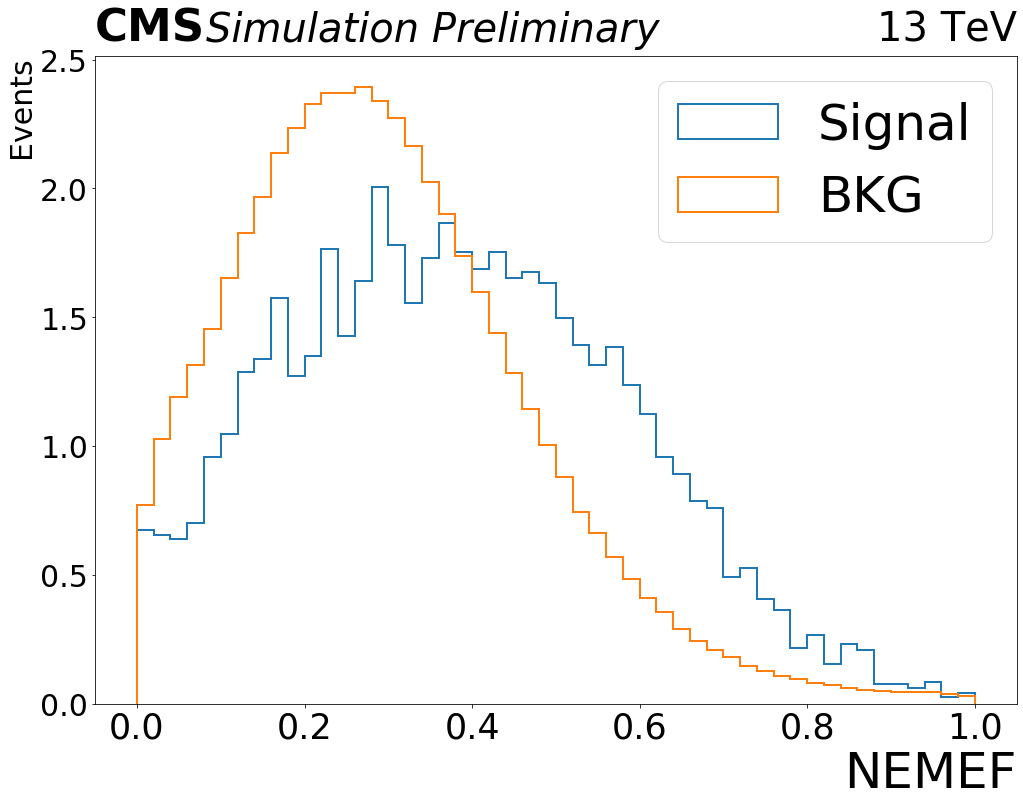

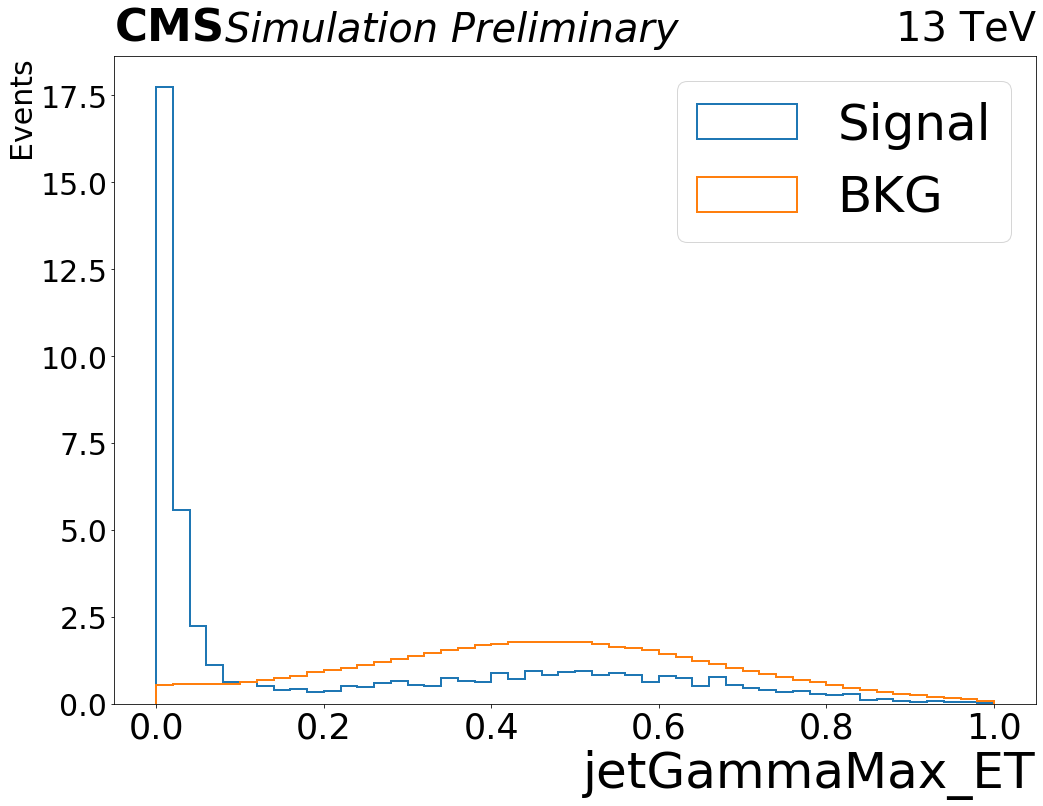

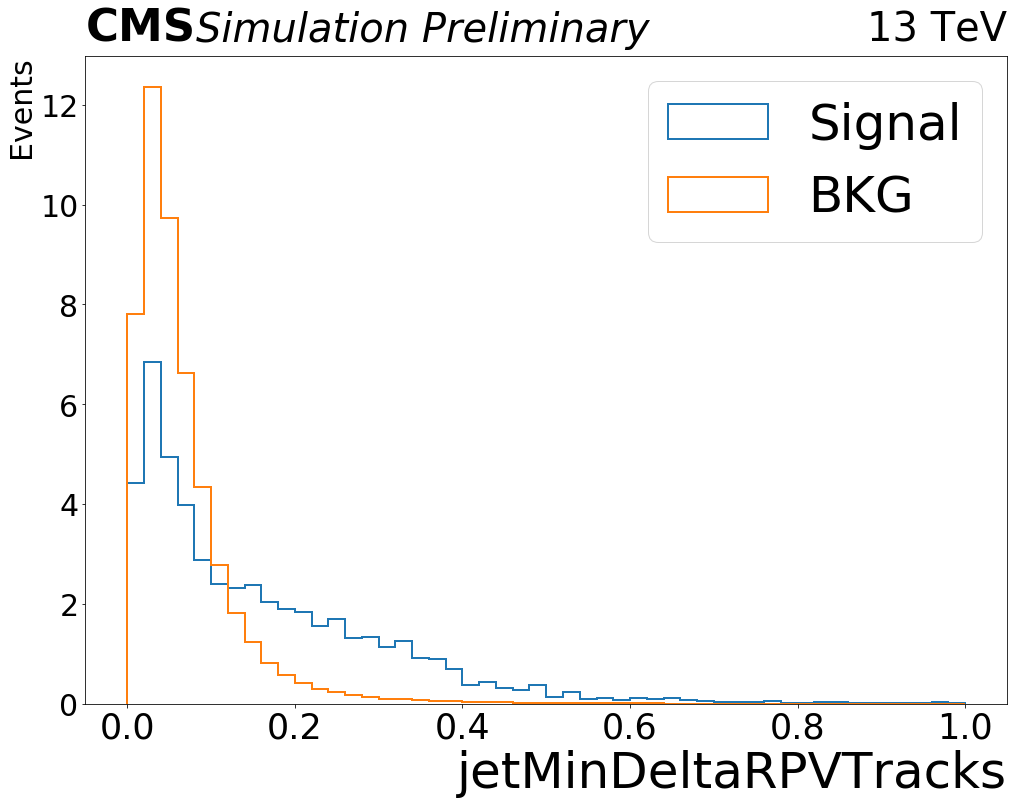

In [52]:
####Plot input variables######
for idx in range(len(variables)):
        f = plt.figure()
        ax = f.add_subplot(111)
        plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
        
#         plt.hist(df_signal[df_signal[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]), weights=sig_flat_w)
#         plt.hist(df_bkg[df_bkg[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]),weights=bkg_flat_w)
        plt.hist(df_signal[variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]), weights=sig_flat_w)
        plt.hist(df_bkg[variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]),weights=bkg_flat_w)

#         if variables[idx][0]=='met':
#             plt.hist(df_signal[df_signal[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
#             plt.hist(df_bkg[df_bkg[variables[idx][0]] > -999][variables[idx][0]], density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
#         else:
#             plt.hist(np.array(df_signal[df_signal[variables[idx][0]] > -999][variables[idx][0]]).flatten(), density=True, alpha=1.0, histtype="step", lw=2, label="Signal", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
#             plt.hist(np.array(df_bkg[df_bkg[variables[idx][0]] > -999][variables[idx][0]]).flatten(), density=True, alpha=1.0, histtype="step", lw=2, label="BKG", bins=variables[idx][3], range=(variables[idx][4], variables[idx][5]))
            
        plt.legend(loc="upper right", fontsize = 50)
        plt.xlabel(variables[idx][2], fontsize=50,horizontalalignment='right', x=1.0)
        plt.ylabel('Events', fontsize=30,horizontalalignment='right', y=1.0)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=30)
        fig = plt.gcf()
        fig.set_size_inches(16, 12)
        plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=45)
        plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=40)
        plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=40)
        plt.draw()
#         plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.pdf')#, bbox_inches='tight')
#         plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.png')#, bbox_inches='tight')
        plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.png', facecolor='w', transparent=False)#, bbox_inches='tight')
#         plt.savefig(plotDir+'variables/'+test_name + '_' + variables[idx][0]+'.eps')#, bbox_inches='tight')


os.system("chmod 755 "+plotDir+"variables/*")

In [53]:
# split data into train and test sets
seed = 7
test_size = 0.4
sample_size = 1.0
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(x, y, sample_w, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)

In [54]:
# fit model no training data
model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200, verbosity=1, n_jobs=4, reg_lambda=1.0)
# model.fit(x_train, y_train)
model.fit(x_train, y_train, sample_weight=w_train)
# model.fit(x_train, y_train, sample_weight=sample_w)

[11:57:06] WARNING: /workspace/src/learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [55]:
#print( dir(model) )
#print(model)
# make predictions for test data
y_pred = model.predict_proba(x_test)[:, 1]
y_pred_train = model.predict_proba(x_train)[:, 1]
y_pred_bkg = model.predict_proba(df_bkg.values)[:, 1]
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

AUC = roc_auc_score(y_test, y_pred)
print("AUC: "+str(AUC))
#get roc curve
#roc = roc_curve(y_test, y_pred)
fpr, tpr, thr = roc_curve(y_test, y_pred)


significance = []
effSignal = []
effBkg = []
thresholds = []

ctr = 0
for i in range(len(fpr)):
    if fpr[i] > 1e-5 and tpr[i] > 1e-5:
#         print("thr = "+str(thr[i])+", fpr = "+str(fpr[i]) + ", tpr = "+str(tpr[i]))
        #print fpr[i], tpr[i] 
        #significance.append(math.sqrt(lumi)*4.8742592356*0.006431528796*tpr[i]/math.sqrt(fpr[i]*0.9935684712))
        significance.append(signalEvents*tpr[i]/math.sqrt(fpr[i]*bkgEvents))
        effSignal.append(tpr[i])
        effBkg.append(fpr[i])
        thresholds.append(thr[i])
        #print significance[ctr], ' ' , fpr[ctr], ' ', tpr[ctr]
        ctr = ctr + 1


max_significance = max(significance)
idx_max_significance = np.argmax(np.array(significance))
best_threshold = thresholds[idx_max_significance]
best_effSignal = effSignal[idx_max_significance]
best_effBkg = effBkg[idx_max_significance]

print("max_significance: "+str(max_significance))
print("best_threshold: "+str(best_threshold))
print("best_effSignal: "+str(best_effSignal))
print("best_effBkg: "+str(best_effBkg))

# idx_WP90 = 0
# minD0p9 = 999.0
# for idx in range(len(effSignal)):
# 	if abs(effSignal[idx] - 0.90) < minD0p9:
# 		idx_WP90 = idx
# 		minD0p9 = abs(effSignal[idx] - 0.90)

# WP90_significance = significance[idx_WP90]
# WP90_threshold = thresholds[idx_WP90]
# WP90_effSignal = effSignal[idx_WP90]
# WP90_effBkg = effBkg[idx_WP90]

# print("WP90_significance: "+str(WP90_significance))
# print("WP90_threshold: "+str(WP90_threshold))
# print("WP90_effSignal: "+str(WP90_effSignal))
# print("WP90_effBkg: "+str(WP90_effBkg))

# idx_WP80 = 0
# minD0p8 = 999.0
# for idx in range(len(effSignal)):
#         if abs(effSignal[idx] - 0.80) < minD0p8:
#                 idx_WP80 = idx
#                 minD0p8 = abs(effSignal[idx] - 0.80)

# WP80_significance = significance[idx_WP80]
# WP80_threshold = thresholds[idx_WP80]
# WP80_effSignal = effSignal[idx_WP80]
# WP80_effBkg = effBkg[idx_WP80]

# print("WP80_significance: "+str(WP80_significance))
# print("WP80_threshold: "+str(WP80_threshold))
# print("WP80_effSignal: "+str(WP80_effSignal))
# print("WP80_effBkg: "+str(WP80_effBkg))

# idx_WP50 = 0
# minD0p5 = 999.0
# for idx in range(len(effSignal)):
#         if abs(effSignal[idx] - 0.50) < minD0p5:
#                 idx_WP50 = idx
#                 minD0p5 = abs(effSignal[idx] - 0.50)

# WP50_significance = significance[idx_WP50]
# WP50_threshold = thresholds[idx_WP50]
# WP50_effSignal = effSignal[idx_WP50]
# WP50_effBkg = effBkg[idx_WP50]

# print("WP50_significance: "+str(WP50_significance))
# print("WP50_threshold: "+str(WP50_threshold))
# print("WP50_effSignal: "+str(WP50_effSignal))
# print("WP50_effBkg: "+str(WP50_effBkg))

#target bkg eff 0.00045
idx_WP_BKG = 0
minD0p5 = 999.0
for idx in range(len(effBkg)):
        if abs(effBkg[idx] - 0.00045) < minD0p5:
                idx_WP_BKG = idx
                minD0p5 = abs(effBkg[idx] - 0.00045)

WP_BKG_significance = significance[idx_WP_BKG]
WP_BKG_threshold = thresholds[idx_WP_BKG]
WP_BKG_effSignal = effSignal[idx_WP_BKG]
WP_BKG_effBkg = effBkg[idx_WP_BKG]

print("WP_BKG_significance: "+str(WP_BKG_significance))
print("WP_BKG_threshold: "+str(WP_BKG_threshold))
print("WP_BKG_effSignal: "+str(WP_BKG_effSignal))
print("WP_BKG_effBkg: "+str(WP_BKG_effBkg))

Accuracy: 99.93%
AUC: 0.8009665700212532
max_significance: 396.7896592728729
best_threshold: 0.953504
best_effSignal: 0.1063193851409052
best_effBkg: 1.1766269181175915e-05
WP_BKG_significance: 183.31538601507265
WP_BKG_threshold: 0.5208906
WP_BKG_effSignal: 0.3035866780529462
WP_BKG_effBkg: 0.00044947148272091994


In [56]:
print("WP_BKG_significance: "+str(WP_BKG_significance))
print("WP_BKG_threshold: "+str(WP_BKG_threshold))
print("WP_BKG_effSignal: "+str(WP_BKG_effSignal))
print("WP_BKG_effBkg: "+str(WP_BKG_effBkg))


WP_BKG_significance: 183.31538601507265
WP_BKG_threshold: 0.5208906
WP_BKG_effSignal: 0.3035866780529462
WP_BKG_effBkg: 0.00044947148272091994


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


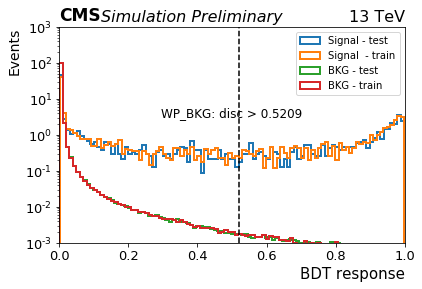

In [57]:
##########################################################
# make histogram of discriminator value for signal and bkg
##########################################################
#pd.DataFrame({'truth':y_test, 'disc':y_pred}).hist(column='disc', by='truth', bins=50)
y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})
disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal - test")
plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal  - train")
plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - test")
plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - train")
plt.yscale("log")
plt.xlim([0.0, 1.0])
plt.ylim([0.001, 1000.0])
plt.legend(loc="upper right")
plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP_BKG_threshold, color="black", linestyle='--')
plt.text(0.5,0.6,'WP_BKG: disc > %.4f'%WP_BKG_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.axvline(x=WP90_threshold, color="black", linestyle='--')
# plt.axvline(x=WP80_threshold, color="black")
# plt.axvline(x=WP50_threshold, color="black")
# plt.text(0.5,0.7,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.5,0.6,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.5,0.5,'WP50: disc > %.4f'%WP50_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.pdf')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.png')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.eps')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0

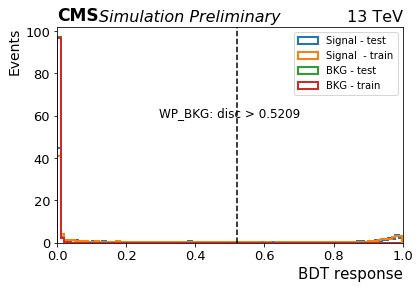

In [58]:
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal - test")
plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal  - train")
plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - test")
plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - train")
plt.yscale("linear")
plt.xlim([0.0, 1.0])
#plt.ylim([0.001, 100.0])
plt.legend(loc="upper right")
plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP_BKG_threshold, color="black", linestyle='--')
plt.text(0.5,0.6,'WP_BKG: disc > %.4f'%WP_BKG_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.axvline(x=WP90_threshold, color="black", linestyle='--')
# plt.axvline(x=WP80_threshold, color="black")
# plt.text(0.5,0.7,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.5,0.6,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.5,0.5,'WP50: disc > %.4f'%WP50_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_linY.pdf')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_linY.png')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_linY.eps')


os.system("chmod 755 "+plotDir+"training/*")



0

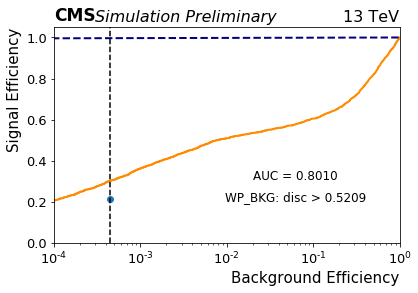

In [59]:
#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xscale('log')
plt.xlim([0.0001, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP_BKG_effBkg, color="black", linestyle='--')
# plt.axvline(y=WP_BKG_effBkg, color="black", linestyle='--')
plt.text(0.7,0.21,'WP_BKG: disc > %.4f'%WP_BKG_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.axhline(y=0.9, color="black", linestyle='--')
# plt.axhline(y=0.8, color="black")
# plt.text(0.02,0.01,'WP50: bkg eff = %.4f'%WP50_effBkg, fontsize=12)
# plt.text(0.02,0.11,'WP80: bkg eff = %.4f'%WP80_effBkg, fontsize=12)
# plt.text(0.02,0.21,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
plt.text(0.02,0.31,'AUC = %.4f'%AUC, fontsize=12)
#plt.title('Receiver operating characteristic example')
#plt.legend(loc="lower right")
#plt.show()
plt.scatter(0.00045, 0.21271, marker='o')
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/myroc_' + test_name + '.pdf')
plt.savefig(plotDir+'training/myroc_' + test_name + '.png')
plt.savefig(plotDir+'training/myroc_' + test_name + '.eps')
os.system("chmod 755 "+plotDir+"training/*")

In [60]:
# # Pickle dictionary using protocol 0.
os.system("mkdir -p "+ plotDir + "models/")
output = open(plotDir+'/models/model_'+test_name+'.pkl', 'wb')
pickle.dump(model, output)
output.close()
model.get_booster().dump_model(plotDir+'models/model_'+test_name+'.txt')
model.get_booster().save_model(plotDir+'models/model_'+test_name+'.xgb')

print("example input and prediction....")
print("bkg sample 1st event input:")
print(df_bkg.values[0])
print("y_pred_bkg first 20 events")
print(y_pred_bkg[:20])

example input and prediction....
bkg sample 1st event input:
[-0.09180707  0.53393173  0.19704212  0.          0.233427    0.4948891
  0.03897956]
y_pred_bkg first 20 events
[0.00412858 0.00520212 0.00291491 0.00248826 0.14463077 0.00379812
 0.00466741 0.0051909  0.00274391 0.00412694 0.00492339 0.00396841
 0.0251772  0.00567791 0.00568836 0.00509638 0.00347777 0.00450923
 0.00825987 0.00390888]


0

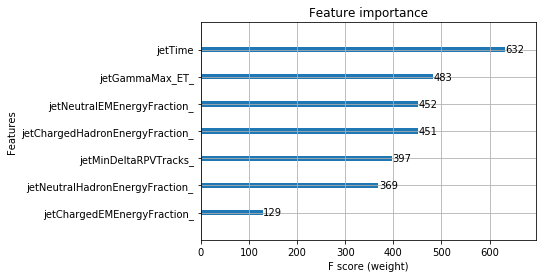

In [61]:
#plot feature importances

model.get_booster().feature_names = [row[1] for row in variables]

xgb.plot_importance(model, max_num_features=len(variables), xlabel="F score (weight)")
plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.pdf', bbox_inches='tight')
plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.png', bbox_inches='tight')
plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.eps', bbox_inches='tight')
os.system("chmod 755 "+plotDir+"training/*")



In [62]:
#xgb.plot_tree( model.get_booster() )
# from graphviz import Digraph
# xgb.plot_tree( model )
# fig = plt.gcf()
# #fig.set_size_inches(500, 50)
# plt.draw()
# plt.savefig(plotDir+'training/myTree_' + test_name + '.pdf')
# plt.savefig(plotDir+'training/myTree_' + test_name + '.png')
# plt.savefig(plotDir+'training/myTree_' + test_name + '.eps')
# os.system("chmod 755 "+plotDir+"training/*")

In [6]:
output = open(plotDir+'/models/model_'+test_name+'.pkl', 'rb')

loaded_model = pickle.load(output)
# print(np.sum(np.ones(len(x_test))))
# result = loaded_model.predict_proba(x_test)
# # result = loaded_model.predict(x_test)
# # result = loaded_model.score(x_test, y_test, sample_weight=w_test)
# # print(x_test)
# print(result)
# print(len(result))

In [174]:
# df_signal = uproot.open(signalFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)
# df_bkg = uproot.open(bkgFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)

# #weight
# #sig
# sig_root_dir = uproot.open(signalFileName) 
# sig_tree = sig_root_dir['BDT_Tree']
# # #branches
# sig_w = sig_tree['weight_'].array() 
# sig_jet_pt = sig_tree['jetPt_'].array()
# from itertools import chain 
# sig_flat_w = [np.array([x]*len(y)) for x,y in zip(sig_w,sig_jet_pt)]
# sig_flat_w = list(chain.from_iterable(sig_flat_w))
# sig_flat_w = [x*137000 for x in sig_flat_w]
# # bkg
# bkg_root_dir = uproot.open(bkgFileName) 
# bkg_tree = bkg_root_dir['BDT_Tree']
# # #branches
# bkg_w = bkg_tree['weight_'].array() 
# bkg_jet_pt = bkg_tree['jetPt_'].array()
# bkg_flat_w = [np.array([x]*len(y)) for x,y in zip(bkg_w,bkg_jet_pt)]
# bkg_flat_w = list(chain.from_iterable(bkg_flat_w)) 
# bkg_flat_w = [x*137000 for x in bkg_flat_w]
# # sample weight
# sample_w = np.concatenate([sig_flat_w,bkg_flat_w])
# print(sig_flat_w[0])
# print(())
# print(len(sig_flat_w))
# print(len(sig_w))
# print(len(sig_jet_pt))
# print(len(sig_jet_pt.flatten()))

## change nan to -999
# df_signal = df_signal.fillna(-999)
# df_bkg = df_bkg.fillna(-999)

##Getting a numpy array out of two pandas data frame

#getting a numpy array from two pandas data frames
# x = np.concatenate([df_bkg.values,df_signal.values])
# #creating numpy array for target variables
# y = np.concatenate([np.zeros(len(df_bkg)),
# np.ones(len(df_signal))])

# split data into train and test sets
# seed = 7
# test_size = 0.4
# sample_size = 1.0
# x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(x, y, sample_w, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)

# # fit model no training data
# model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=400, verbosity=2, n_jobs=4, reg_lambda=1.0)
# # model.fit(x_train, y_train)
# model.fit(x_train, y_train, sample_weight=w_train)
# # model.fit(x_train, y_train, sample_weight=sample_w)

# #print( dir(model) )
# #print(model)
# # make predictions for test data
# y_pred = model.predict_proba(x_test)[:, 1]
# y_pred_train = model.predict_proba(x_train)[:, 1]
# y_pred_bkg = model.predict_proba(df_bkg.values)[:, 1]
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

# AUC = roc_auc_score(y_test, y_pred)
# print("AUC: "+str(AUC))
# #get roc curve
# #roc = roc_curve(y_test, y_pred)
# fpr, tpr, thr = roc_curve(y_test, y_pred)

# y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
# y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})
# disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
# disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
# disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
# disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
 

# f = plt.figure()
# ax = f.add_subplot(111)
# plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
# plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal - test")
# plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal  - train")
# plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - test")
# plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - train")
# plt.yscale("log")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.001, 1000.0])
# plt.legend(loc="upper right")
# plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
# plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.axvline(x=WP_BKG_threshold, color="black", linestyle='--')
# plt.text(0.5,0.6,'WP_BKG: disc > %.4f'%WP_BKG_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
# plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
# plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.png')


In [59]:
# signal and bkg file normalized
dataDir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/skimmed/'
#sig 
signalFileName = dataDir + 'skim_sig_hh200_1lep_allmt.root'
# signalFileName = dataDir + 'skim_sig_hh200_1lep.root'
# signalFileName = dataDir + 'skim_sig_hh200_unmatch.root'
# signalFileName = dataDir + 'skim_sig_hh200.root'
signalFile = rt.TFile(signalFileName)
signalTree = signalFile.Get('BDT_Tree')
signalEvents = lumi_sf_sig*signalTree.GetEntries()

#bkg
# bkgFileName    = dataDir + 'skim_qcd_ht_all.root'
# bkgFileName    = dataDir + 'skim_qcd_ht_500_700.root'
# bkgFileName    = dataDir + 'skim_bkg_1lep_norm_all.root'
# bkgFileName    = dataDir + 'skim_qcd_1lep_norm_all.root'
# bkgFileName    = dataDir + 'skim_znunu_1lep_norm_all.root'
# bkgFileName    = dataDir + 'skim_ttjets_1lep_norm_all.root'
# bkgFileName    = dataDir + 'skim_wjets_1lep_norm_all.root'
bkgFileName    = dataDir + 'skim_bkg_1lep_allmt_norm_all.root'
# bkgFileName    = dataDir + 'skim_bkg_1lep_norm_all.root'
# bkgFileName    = dataDir + 'skim_bkg_norm_all.root'
# bkgFileName    = dataDir + 'skim_bkg_all.root'
# bkgFileName    = dataDir + 'out_bkg.root'
# bkgFileName    = dataDir + 'bdt_qcd_bkg.root'
bkgFile = rt.TFile(bkgFileName)
bkgTree = bkgFile.Get('BDT_Tree')
bkgEvents = lumi_sf_bkg*bkgTree.GetEntries()

print('[INFO]: S =' + str(signalEvents) + '; B =' + str(bkgEvents) +"; S/sqrt(B) = " + str(signalEvents/math.sqrt(bkgEvents)))

df_signal = uproot.open(signalFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)
df_bkg = uproot.open(bkgFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)

df_signal = df_signal.fillna(-999)
df_bkg = df_bkg.fillna(-999)


[INFO]: S =9179.0; B =27082708.0; S/sqrt(B) = 1.7637999510418632


In [61]:
#WP_BKG_threshold: 0.9998192
# WP_BKG_threshold=0.004737257
WP_BKG_threshold=0.5208906
tar_thr = WP_BKG_threshold
# tar_thr = 0.9998192 #WP_BKG_threshold

xall_sig = df_signal.to_numpy()
yall_sig_pred = loaded_model.predict_proba(xall_sig)[:,1]

# print(yall_sig_pred)
print(sum(yall_sig_pred))

print(len(yall_sig_pred))
print(len(xall_sig))

#sig
sig_root_dir = uproot.open(signalFileName) 
sig_tree = sig_root_dir['BDT_Tree']
# #branches
sig_w = sig_tree['weight_'].array() 
sig_jet_pt = sig_tree['jetPt_'].array()
sig_jet_nj = np.array([len(x) for x in sig_jet_pt]) 
print(len(sig_w))

yall_sig_pred_evt = []
sig_jet_py = []
cnt = 0
for evt in range(len(sig_w)):
    tmp_y = []
    tmp_py = []
    tmp_nj = len(sig_jet_pt[evt])
    if tmp_nj>0:
        for j in range(tmp_nj):
            tmp_y.append(yall_sig_pred[cnt])
            if yall_sig_pred[cnt] > tar_thr :
                tmp_py.append(1)
            else:
                tmp_py.append(0)     
            cnt += 1 
            
    yall_sig_pred_evt.append(tmp_y)
    sig_jet_py.append(tmp_py)

    
print(len(sig_jet_py))
# print(sig_jet_py)
# print(np.unique(sig_jet_py))

# sig_jet_sy = np.array([sum(x) for x in yall_sig_pred_evt]) 
sig_jet_sy = np.array([sum(x) for x in sig_jet_py]) 
print(len(sig_jet_sy))
print(sum(sig_jet_sy))
# print(sig_jet_sy)
print(np.unique(sig_jet_sy))

25.243370122130727
122
122
67
67
67
23
[0 1]


In [62]:
xall_bkg = df_bkg.to_numpy()
yall_bkg_pred = loaded_model.predict_proba(xall_bkg)[:,1]
    
# print(yall_bkg_pred)
print(sum(yall_bkg_pred))

print(len(yall_bkg_pred))
print(len(xall_bkg))

#bkg
bkg_root_dir = uproot.open(bkgFileName) 
bkg_tree = bkg_root_dir['BDT_Tree']
# #branches
bkg_w = bkg_tree['weight_'].array() 
bkg_jet_pt = bkg_tree['jetPt_'].array()
bkg_jet_nj = np.array([len(x) for x in bkg_jet_pt]) 
print(len(bkg_w))

yall_bkg_pred_evt = []
bkg_jet_py = []
cnt = 0
for evt in range(len(bkg_w)):
    tmp_y = []
    tmp_py = []
    tmp_nj = len(bkg_jet_pt[evt])
    
    if tmp_nj>0:
        for j in range(tmp_nj):
            tmp_y.append(yall_bkg_pred[cnt])
            if yall_bkg_pred[cnt] > tar_thr :
                tmp_py.append(1)
            else:
                tmp_py.append(0)     
            cnt += 1 
            
    yall_bkg_pred_evt.append(tmp_y)
    bkg_jet_py.append(tmp_py)

    
print(len(bkg_jet_py))

# sig_jet_sy = np.array([sum(x) for x in yall_sig_pred_evt]) 
sig_jet_sy = np.array([sum(x) for x in sig_jet_py]) 
print(len(sig_jet_sy))
print(sum(sig_jet_sy))
# print(sig_jet_sy)
# print(np.unique(sig_jet_sy))
    

# bkg_jet_sy = np.array([sum(x) for x in yall_bkg_pred_evt]) 
bkg_jet_sy = np.array([sum(x) for x in bkg_jet_py]) 
print(len(bkg_jet_sy))
print(sum(bkg_jet_sy))
# print(bkg_jet_sy)
print(np.unique(bkg_jet_sy))
    

3466.7714699682438
537106
537106
197684
197684
67
23
197684
254
[0 1]


In [71]:
print(np.unique(bkg_jet_sy))
print(np.unique(sig_jet_sy))

[0 1 2 3]
[0 1 2 3 4]


137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/CR_nTags_0-5.png has been created


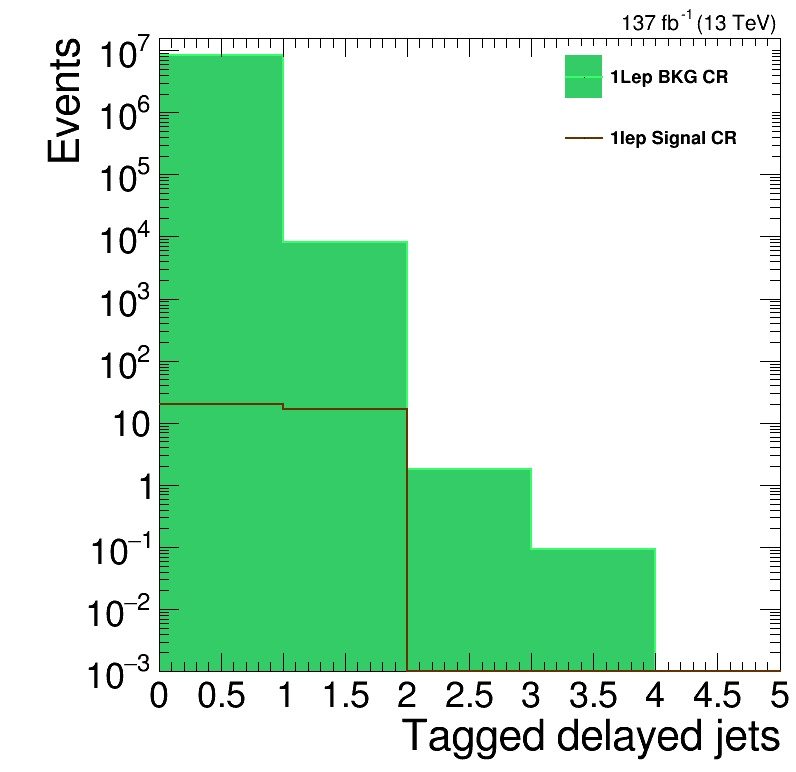

In [84]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.70,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
stack = rt.THStack( "hs" , "Hgg Stack " )
total = rt.TH1D('total','total',3,0,3)
color_list = [845,800,861,806,876,597,625]

i=0
h['bkg'] = create_TH1D( bkg_jet_sy, axis_title=['Tagged delayed jets', 'Events'], name='bkg', binning=[5,0,5],weights = bkg_w*137000)

h['bkg'].SetLineColor(color_list[i]+3)
h['bkg'].SetFillColor(color_list[i])
h['bkg'].SetMinimum(1e-3)
leg.AddEntry(h['bkg'],'1Lep BKG CR')
# leg.AddEntry(h['bkg'],'BKG')

h['bkg'].Draw('Histsame')

i=1
h['sig'] = create_TH1D( sig_jet_sy, axis_title=['Tagged delayed jets', 'Events'], name='sig', binning=[5,0,5],weights = sig_w*137000)

h['sig'].SetLineColor(color_list[i]+3)
# h['sig'].SetFillColor(color_list[i])
leg.AddEntry(h['sig'],'1lep Signal CR')
# leg.AddEntry(h['sig'],'Signal')

h['sig'].Draw('Histsame')



leg.Draw()


CMS_lumi.lumi_13TeV = "137 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


# if setlog: 
#     c.SetLogy()
c.SetLeftMargin(0.2)
c.SetLogy()
c.Draw()
# c.SaveAs(plotDir+'CR_nTags_0-5.png')
# c.SaveAs(plotDir+'nTags_0-5.png')


197684
197684
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/CR_allmt_nTags_0-2.png has been created


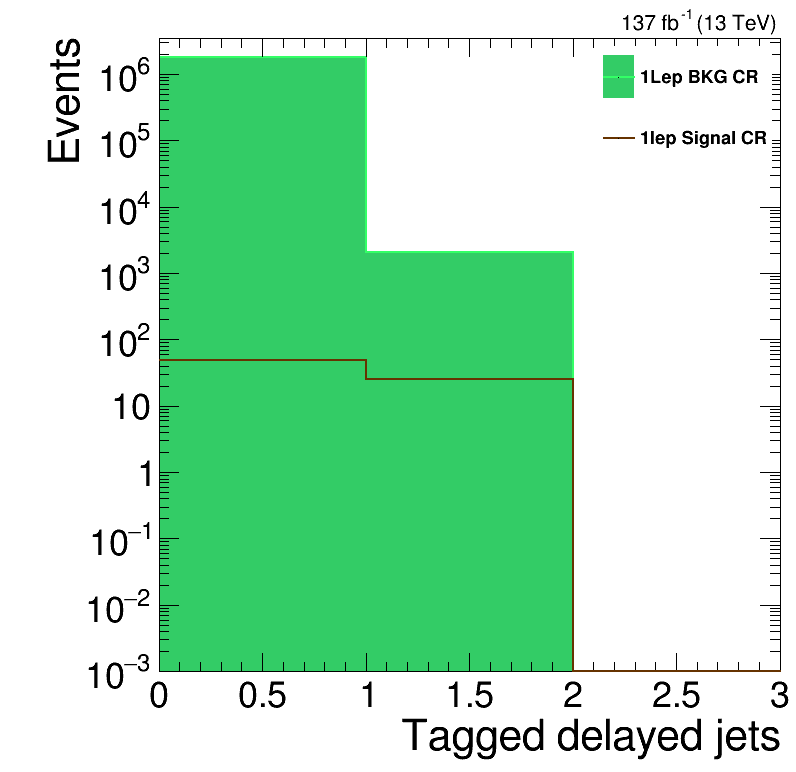

In [63]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.75,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
stack = rt.THStack( "hs" , "Hgg Stack " )
total = rt.TH1D('total','total',3,0,3)
color_list = [845,800,861,806,876,597,625]

i=0

bkg_sy = bkg_jet_sy
print(len(bkg_jet_sy))
j=0
for j,ele in enumerate(bkg_jet_sy):
    if ele > 2:
        bkg_sy[j] = 2
    else:
        bkg_sy[j] = ele
        
print(len(bkg_sy))

        
h['bkg'] = create_TH1D( bkg_sy, axis_title=['Tagged delayed jets', 'Events'], name='bkg', binning=[3,0,3],weights = bkg_w*137000)

h['bkg'].SetLineColor(color_list[i]+3)
h['bkg'].SetFillColor(color_list[i])
h['bkg'].SetMinimum(1e-3)
# leg.AddEntry(h['bkg'],'BKG')
leg.AddEntry(h['bkg'],'1Lep BKG CR')

h['bkg'].Draw('Histsame')

i=1

sig_sy = sig_jet_sy
k=0
for k,ele in enumerate(sig_jet_sy):
    if ele > 2:
        sig_sy[k] = 2
    else:
        sig_sy[k] = ele
        
h['sig'] = create_TH1D( sig_sy, axis_title=['Tagged delayed jets', 'Events'], name='sig', binning=[3,0,3],weights = sig_w*137000)

h['sig'].SetLineColor(color_list[i]+3)
# h['sig'].SetFillColor(color_list[i])
leg.AddEntry(h['sig'],'1lep Signal CR')
# leg.AddEntry(h['sig'],'Signal')

h['sig'].Draw('Histsame')



leg.Draw()


CMS_lumi.lumi_13TeV = "137 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


# if setlog: 
#     c.SetLogy()
c.SetLeftMargin(0.2)
c.SetLogy()
c.Draw()
# c.SaveAs(plotDir+'CR_qcd_nTags_0-2.png')
# c.SaveAs(plotDir+'CR_znunu_nTags_0-2.png')
# c.SaveAs(plotDir+'CR_ttjets_nTags_0-2.png')
# c.SaveAs(plotDir+'CR_wjets_nTags_0-2.png')
# c.SaveAs(plotDir+'CR_nTags_0-2.png')
c.SaveAs(plotDir+'CR_allmt_nTags_0-2.png')
# c.SaveAs(plotDir+'nTags_0-2.png')


In [64]:
print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0]) )
print('bin 1', sum(sig_w[sig_sy==1]) )
print('bin 2', sum(sig_w[sig_sy==2]) )
print('all mt bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0]) )
print('bin 1', sum(bkg_w[bkg_sy==1]) )
print('bin 2', sum(bkg_w[bkg_sy==2]) )

print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0])*137000 )
print('bin 1', sum(sig_w[sig_sy==1])*137000 )
print('bin 2', sum(sig_w[sig_sy==2])*137000 )
print('all mt bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0])*137000 )
print('bin 1', sum(bkg_w[bkg_sy==1])*137000 )
print('bin 2', sum(bkg_w[bkg_sy==2])*137000 )


sig hh200 1lep CR
bin 0 0.0003571052657207474
bin 1 0.00018666866162675433
bin 2 0
all mt bkg 1lep CR
bin 0 13.359825556619757
bin 1 0.015132514271545716
bin 2 0
sig hh200 1lep CR
bin 0 48.923421403742395
bin 1 25.573606642865343
bin 2 0
all mt bkg 1lep CR
bin 0 1830296.1012569068
bin 1 2073.154455201763
bin 2 0


In [98]:
print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0]) )
print('bin 1', sum(sig_w[sig_sy==1]) )
print('bin 2', sum(sig_w[sig_sy==2]) )
print('ttjets bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0]) )
print('bin 1', sum(bkg_w[bkg_sy==1]) )
print('bin 2', sum(bkg_w[bkg_sy==2]) )

print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0])*137000 )
print('bin 1', sum(sig_w[sig_sy==1])*137000 )
print('bin 2', sum(sig_w[sig_sy==2])*137000 )
print('ttjets bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0])*137000 )
print('bin 1', sum(bkg_w[bkg_sy==1])*137000 )
print('bin 2', sum(bkg_w[bkg_sy==2])*137000 )


sig hh200 1lep CR
bin 0 0.00014608851779485121
bin 1 0.00012174043149570934
bin 2 0
ttjets bkg 1lep CR
bin 0 1.6352463380535482
bin 1 0.0023641749903617892
bin 2 0
sig hh200 1lep CR
bin 0 20.014126937894616
bin 1 16.67843911491218
bin 2 0
ttjets bkg 1lep CR
bin 0 224028.7483133361
bin 1 323.8919736795651
bin 2 0


In [94]:
print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0]) )
print('bin 1', sum(sig_w[sig_sy==1]) )
print('bin 2', sum(sig_w[sig_sy==2]) )
print('znunu bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0]) )
print('bin 1', sum(bkg_w[bkg_sy==1]) )
print('bin 2', sum(bkg_w[bkg_sy==2]) )

print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0])*137000 )
print('bin 1', sum(sig_w[sig_sy==1])*137000 )
print('bin 2', sum(sig_w[sig_sy==2])*137000 )
print('znunu bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0])*137000 )
print('bin 1', sum(bkg_w[bkg_sy==1])*137000 )
print('bin 2', sum(bkg_w[bkg_sy==2])*137000 )


sig hh200 1lep CR
bin 0 0.00014608851779485121
bin 1 0.00012174043149570934
bin 2 0
znunu bkg 1lep CR
bin 0 0.0015549033281985203
bin 1 5.669446530021105e-07
bin 2 0
sig hh200 1lep CR
bin 0 20.014126937894616
bin 1 16.67843911491218
bin 2 0
znunu bkg 1lep CR
bin 0 213.02175596319728
bin 1 0.07767141746128914
bin 2 0


In [90]:
print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0]) )
print('bin 1', sum(sig_w[sig_sy==1]) )
print('bin 2', sum(sig_w[sig_sy==2]) )
print('qcd bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0]) )
print('bin 1', sum(bkg_w[bkg_sy==1]) )
print('bin 2', sum(bkg_w[bkg_sy==2]) )

print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0])*137000 )
print('bin 1', sum(sig_w[sig_sy==1])*137000 )
print('bin 2', sum(sig_w[sig_sy==2])*137000 )
print('qcd bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0])*137000 )
print('bin 1', sum(bkg_w[bkg_sy==1])*137000 )
print('bin 2', sum(bkg_w[bkg_sy==2])*137000 )


sig hh200 1lep CR
bin 0 0.00014608851779485121
bin 1 0.00012174043149570934
bin 2 0
qcd bkg 1lep CR
bin 0 0.04289418107600795
bin 1 8.149330096784979e-05
bin 2 0
sig hh200 1lep CR
bin 0 20.014126937894616
bin 1 16.67843911491218
bin 2 0
qcd bkg 1lep CR
bin 0 5876.50280741309
bin 1 11.164582232595421
bin 2 0


In [102]:
print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0]) )
print('bin 1', sum(sig_w[sig_sy==1]) )
print('bin 2', sum(sig_w[sig_sy==2]) )
print('all bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0]) )
print('bin 1', sum(bkg_w[bkg_sy==1]) )
print('bin 2', sum(bkg_w[bkg_sy==2]) )

print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0])*137000 )
print('bin 1', sum(sig_w[sig_sy==1])*137000 )
print('bin 2', sum(sig_w[sig_sy==2])*137000 )
print('all bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0])*137000 )
print('bin 1', sum(bkg_w[bkg_sy==1])*137000 )
print('bin 2', sum(bkg_w[bkg_sy==2])*137000 )


sig hh200 1lep CR
bin 0 0.00014608851779485121
bin 1 0.00012174043149570934
bin 2 0
all bkg 1lep CR
bin 0 11.891572688170001
bin 1 0.01424123773744057
bin 2 0
sig hh200 1lep CR
bin 0 20.014126937894616
bin 1 16.67843911491218
bin 2 0
all bkg 1lep CR
bin 0 1629145.4582792902
bin 1 1951.0495700293582
bin 2 0


In [81]:
print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0]) )
print('bin 1', sum(sig_w[sig_sy==1]) )
print('bin 2', sum(sig_w[sig_sy==2]) )
print('wjets bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0]) )
print('bin 1', sum(bkg_w[bkg_sy==1]) )
print('bin 2', sum(bkg_w[bkg_sy==2]) )

print('sig hh200 1lep CR')
print('bin 0', sum(sig_w[sig_sy==0])*137000 )
print('bin 1', sum(sig_w[sig_sy==1])*137000 )
print('bin 2', sum(sig_w[sig_sy==2])*137000 )
print('wjets bkg 1lep CR')
print('bin 0', sum(bkg_w[bkg_sy==0])*137000 )
print('bin 1', sum(bkg_w[bkg_sy==1])*137000 )
print('bin 2', sum(bkg_w[bkg_sy==2])*137000 )


sig hh200 1lep CR
bin 0 0.00014608851779485121
bin 1 0.00012174043149570934
bin 2 0
wjets bkg 1lep CR
bin 0 10.211877265712246
bin 1 0.01179500250145793
bin 2 0
sig hh200 1lep CR
bin 0 20.014126937894616
bin 1 16.67843911491218
bin 2 0
wjets bkg 1lep CR
bin 0 1399027.1854025777
bin 1 1615.9153426997364
bin 2 0


In [74]:
print('sig hh200')
print('bin 0', sum(sig_w[sig_sy==0]) )
print('bin 1', sum(sig_w[sig_sy==1]) )
print('bin 2', sum(sig_w[sig_sy==2]) )
print('bkg')
print('bin 0', sum(bkg_w[bkg_sy==0]) )
print('bin 1', sum(bkg_w[bkg_sy==1]) )
print('bin 2', sum(bkg_w[bkg_sy==2]) )

print('sig hh200')
print('bin 0', sum(sig_w[sig_sy==0])*137000 )
print('bin 1', sum(sig_w[sig_sy==1])*137000 )
print('bin 2', sum(sig_w[sig_sy==2])*137000 )
print('bkg')
print('bin 0', sum(bkg_w[bkg_sy==0])*137000 )
print('bin 1', sum(bkg_w[bkg_sy==1])*137000 )
print('bin 2', sum(bkg_w[bkg_sy==2])*137000 )


sig hh200
bin 0 0.011808821855083806
bin 1 0.010080107727844734
bin 2 0.002264372025820194
bkg
bin 0 60.3000282278898
bin 1 0.06001373679218602
bin 2 1.3683867397418226e-05
sig hh200
bin 0 1617.8085941464815
bin 1 1380.9747587147285
bin 2 310.21896753736655
bkg
bin 0 8261103.867220902
bin 1 8221.881940529485
bin 2 1.874689833446297


In [4]:
tags = []
tags = [
        'QCD_HT_all, background',
        'WLNu_HT_all, background',
#         'WLNu, background',
        'ZNunu_HT_all, background',
        'TT_Lep, background',
        'H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/'

# file names

fnames = {}

fnames['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh127_unmatch.root'
fnames['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh200_unmatch.root'
fnames['H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh400_unmatch.root'
# fnames['QCD_HT_all, background'] = 'skimmed/skim_qcd_ht_all.root'
# fnames['WLNu, background'] = 'skimmed/skim_wjets_all.root'
# fnames['ZNunu_HT_all, background'] = 'skimmed/skim_znunu_all.root'
# fnames['TT_Lep, background'] = 'skimmed/skim_ttjets_all.root'
fnames['QCD_HT_all, background'] = 'skimmed/skim_qcd_norm_all.root'
fnames['WLNu_HT_all, background'] = 'skimmed/skim_wjets_norm_all.root'
# fnames['WLNu, background'] = 'skimmed/skim_wjets_norm_all.root'
fnames['ZNunu_HT_all, background'] = 'skimmed/skim_znunu_norm_all.root'
fnames['TT_Lep, background'] = 'skimmed/skim_ttjets_norm_all.root'
# fnames['All, background'] = 'skimmed/skim_bkg_all.root'

#1lep MT<100 CR
# fnames['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh127_1lep.root'
# fnames['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh200_1lep.root'
# fnames['H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh400_1lep.root'
# fnames['QCD_HT_all, background'] = 'skimmed/skim_qcd_1lep_norm_all.root'
# fnames['WLNu, background'] = 'skimmed/skim_wjets_1lep_norm_all.root'
# fnames['ZNunu_HT_all, background'] = 'skimmed/skim_znunu_1lep_norm_all.root'
# fnames['TT_Lep, background'] = 'skimmed/skim_ttjets_1lep_norm_all.root'

#1lep all MT
# fnames['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh127_1lep_allmt.root'
# fnames['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh200_1lep_allmt.root'
# fnames['H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m'] =  'skimmed/skim_sig_hh400_1lep_allmt.root'
# fnames['QCD_HT_all, background'] = 'skimmed/skim_qcd_1lep_allmt_norm_all.root'
# fnames['WLNu, background'] = 'skimmed/skim_wjets_1lep_allmt_norm_all.root'
# fnames['ZNunu_HT_all, background'] = 'skimmed/skim_znunu_1lep_allmt_norm_all.root'
# fnames['TT_Lep, background'] = 'skimmed/skim_ttjets_1lep_allmt_norm_all.root'

# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['BDT_Tree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET_'].array()
    print(jet_amax[:10])
    jet_amax = v['weight_'].array()
    print(jet_amax[:10])
     


/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/skimmed/skim_qcd_norm_all.root
Open ready
QCD_HT_all, background
Tree ready
<TTree b'BDT_Tree' at 0x7f9ab0d7a390> OrderedDict([('QCD_HT_all, background', <TTree b'BDT_Tree' at 0x7f9ab0d7a390>)])
[[0.56389445 0.76201355 0.121609695 1.784096] [0.752954] [0.3412648] ... [0.4527527 0.24057089] [0.34564492 0.48366138 0.68294764] [0.9183365]]
[8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05
 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05]
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/skimmed/skim_wjets_norm_all.root
Open ready
WLNu_HT_all, background
Tree ready
<TTree b'BDT_Tree' at 0x7f9aacf15080> OrderedDict([('QCD_HT_all, background', <TTree b'BDT_Tree' at 0x7f9ab0d7a390>), ('WLNu_HT_all, background', <TTree b'BDT_Tree' at 0x7f9aacf15080>)])
[[0.6531102] [] [0.6886658] ... [] [0.28847602 0.66019386] [0.14242859]]
[2.4313593e-05 2.4313593e-05 2.4313593e-05 2.4313593e-05 2.4313593e-05


In [5]:
## Variables
 
time_cut = 0.29612602020051926
tmf_et_cut = 0.12643216674114655
delta_r_cut = 0.03974751272644846
chef_cut = 0.08572597974855801

trg_jet_pt = {}
 
trg_jet_w = {}
trg_flat_w = {}

trg_jet_t = {}
trg_jet_tmf = {}
trg_jet_chef = {}
trg_jet_dr = {}

trg_jet_nj = {}
from itertools import chain 
trg_jet_mt = {}

nTags = {}

for k,v in tree.items():
    print(k,v)


    trg_jet_pt[k] = {}
    trg_jet_w[k] = {}
    trg_flat_w[k] = {}

    # branches
#     mt = v['MT_'].array()
    nj = v['nJets_'].array()
    pt = v['jetPt_'].array()
    t = v['jetTime_'].array()
    tmf = v['jetGammaMax_ET_'].array()
    chef = v['jetChargedHadronEnergyFraction_'].array()
    dr = v['jetMinDeltaRAllTracks_'].array()

    weight = v['weight_'].array()
    
    print(weight.shape)
    print(pt.shape)
    

    basic_jet_str = np.logical_and(1,1)
    met_trg_str = np.logical_and(1,1)

    #apply basic cut string
    # separate jagged jet array req. and event level req.
    trg_jet_pt[k] = pt 

    trg_jet_w[k] = weight 
    trg_jet_nj[k] = nj 
#     trg_jet_mt[k] = mt 
    
    trg_jet_t[k] = t 
    trg_jet_tmf[k] = tmf 
    trg_jet_chef[k] = chef 
    trg_jet_dr[k] = dr 
    
    #remove empty part in jet
#     trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>0]
#     trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>0]
    
#     trg_jet_t[k] = trg_jet_t[k][trg_jet_pt[k].count()>0]
#     trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>0]
#     trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>0]
#     trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>0]
    
#     trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>0]
    
#     #flat weight
    trg_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    trg_flat_w[k] = list(chain.from_iterable(trg_flat_w[k])) 
    
    #print out check
 
    print(trg_jet_w[k][:10])
 
    print(len(trg_jet_w[k]))
    print(trg_jet_pt[k][:10])
 
    

QCD_HT_all, background <TTree b'BDT_Tree' at 0x7f9ab0d7a390>
(302029,)
(302029,)
[8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05
 8.14933e-05 8.14933e-05 8.14933e-05 8.14933e-05]
302029
[[268.03952 128.13936 125.63229 32.900238] [312.2129] [355.04816] ... [691.2101 422.22046] [325.49228 290.09674 34.6271] [132.83643]]
WLNu_HT_all, background <TTree b'BDT_Tree' at 0x7f9aacf15080>
(1832754,)
(1832754,)
[2.4313593e-05 2.4313593e-05 2.4313593e-05 2.4313593e-05 2.4313593e-05
 2.4313593e-05 2.4313593e-05 2.4313593e-05 2.4313593e-05 2.4313593e-05]
1832754
[[198.17122] [] [164.14299] ... [] [202.98602 47.063244] [175.91463]]
ZNunu_HT_all, background <TTree b'BDT_Tree' at 0x7f9aacf280b8>
(6669041,)
(6669041,)
[1.4206424e-05 1.4206424e-05 1.4206424e-05 1.4206424e-05 1.4206424e-05
 1.4206424e-05 1.4206424e-05 1.4206424e-05 1.4206424e-05 1.4206424e-05]
6669041
[[47.201454] [173.31816] [157.91203] ... [223.9785] [230.07268] [161.77103]]
TT_Lep, background <TTree b'BDT_Tree'

QCD_HT_all, background 302029
QCD_HT_all, background bin 0  9.346427320934708
QCD_HT_all, background bin 1  0.011624024635239039
QCD_HT_all, background bin 2  0
unique nTags element:  [0 1]
WLNu_HT_all, background 1832754
WLNu_HT_all, background bin 0  12.490792301343134
WLNu_HT_all, background bin 1  0.01767639571193058
WLNu_HT_all, background bin 2  6.403638487029184e-05
unique nTags element:  [0 1 2]
ZNunu_HT_all, background 6669041
ZNunu_HT_all, background bin 0  13.311870941419613
ZNunu_HT_all, background bin 1  0.009388016770614627
ZNunu_HT_all, background bin 2  3.708566715943107e-06
unique nTags element:  [0 1 2]
TT_Lep, background 292177
TT_Lep, background bin 0  4.523419011866281
TT_Lep, background bin 1  0.012171793518064078
TT_Lep, background bin 2  1.4302127055998426e-05
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m 2254
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 0  0.10446575975220185
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 1  0.024111952334351372


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200324/nTags_cut_based.png has been created


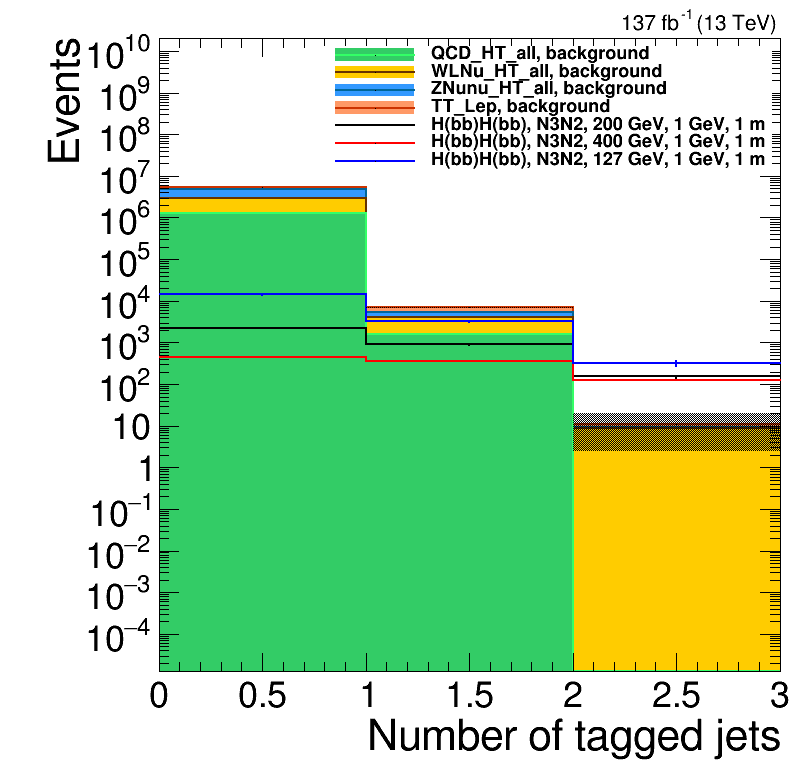

In [7]:
# plot the optimized situation
plotting = True

 
time_cuts = [0.29612602020051926] 
tmf_et_cuts = [0.12643216674114655] 
delta_r_cuts = [0.03974751272644846]
chef_cuts = [0.08572597974855801]

validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
 
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.78,0.97,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
#                     keys = []
                    keys = ['QCD_HT_all, background', 'WLNu_HT_all, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#                     keys = ['QCD_HT_all, background', 'WLNu, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#                     keys = ['All, background']
#                     keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m', ]
#                     sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m' ]
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*1e+03)
                    print('max_value',max_value)
                    stack.SetMinimum(10e-5)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
#                     c.SaveAs(plotDir+'nTags_cut_based_1lep_allmt.png')
#                     c.SaveAs(plotDir+'nTags_cut_based_1lep.png')
#                     c.SaveAs(plotDir+'nTags_cut_based_norm.png')
                    c.SaveAs(plotDir+'nTags_cut_based.png')


In [8]:
for k,T in trg_jet_tmf.items():
    print(k, len(T))
    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))

QCD_HT_all, background 302029
QCD_HT_all, background bin 0  9.346427320934708
QCD_HT_all, background bin 1  0.011624024635239039
QCD_HT_all, background bin 2  0
WLNu_HT_all, background 1832754
WLNu_HT_all, background bin 0  12.490792301343134
WLNu_HT_all, background bin 1  0.01767639571193058
WLNu_HT_all, background bin 2  6.403638487029184e-05
ZNunu_HT_all, background 6669041
ZNunu_HT_all, background bin 0  13.311870941419613
ZNunu_HT_all, background bin 1  0.009388016770614627
ZNunu_HT_all, background bin 2  3.708566715943107e-06
TT_Lep, background 292177
TT_Lep, background bin 0  4.523419011866281
TT_Lep, background bin 1  0.012171793518064078
TT_Lep, background bin 2  1.4302127055998426e-05
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m 2254
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 0  0.10446575975220185
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 1  0.024111952334351372
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 2  0.002382144688453991
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2976
H(bb)H(bb), N

In [12]:
for k,T in trg_jet_tmf.items():
    print(k, len(T))
    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))

QCD_HT_all, background 302029
QCD_HT_all, background bin 0  9.346427320934708
QCD_HT_all, background bin 1  0.011624024635239039
QCD_HT_all, background bin 2  0
WLNu, background 140505
WLNu, background bin 0  33.089935917640105
WLNu, background bin 1  0.05520061170682311
WLNu, background bin 2  0
ZNunu_HT_all, background 6669041
ZNunu_HT_all, background bin 0  13.311870941419613
ZNunu_HT_all, background bin 1  0.009388016770614627
ZNunu_HT_all, background bin 2  3.708566715943107e-06
TT_Lep, background 292177
TT_Lep, background bin 0  4.523419011866281
TT_Lep, background bin 1  0.012171793518064078
TT_Lep, background bin 2  1.4302127055998426e-05
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m 2254
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 0  0.10446575975220185
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 1  0.024111952334351372
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m bin 2  0.002382144688453991
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2976
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.016467422366986

PLOTTING
QCD_HT_all, background 1314
WLNu, background 47298
ZNunu_HT_all, background 8783
TT_Lep, background 140289
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m factor 0.5970149852857494
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1
cnt H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 0 0.0
H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m factor 0.8274335548313334
H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m 2
cnt H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m 0 0.0
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m factor 0.6071427906946789
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m 4
cnt H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m 0 0.0
total 0.0 0.0
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: QCD_HT_all, background (30, 0.000000, 1000.000000)
Warning in <TROOT::Append>: Replacing existing TH1: WLNu, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Error in <Merge>: Cannot merge histograms - limits are inconsistent:
 first: total (3, 0.000000, 3.000000), second: WLNu, b

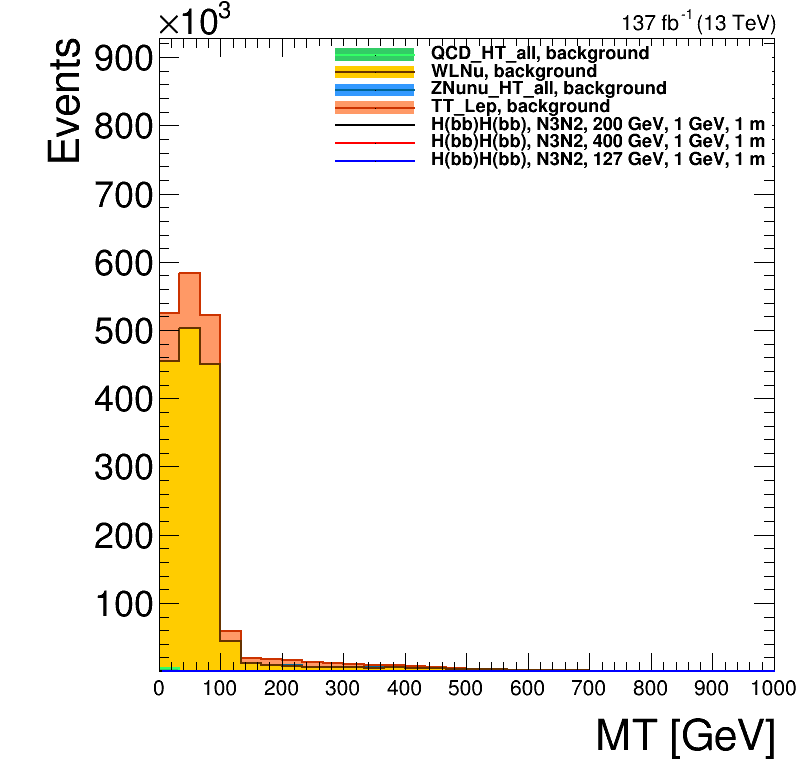

In [52]:
print('PLOTTING')

x_axis = 'MT [GeV]'
y_axis = 'Events'
# axis_set = ['jetPt [GeV]', 'Events']
axis_set = [x_axis, y_axis]
# bin_set = [30,0,100]
bin_set = [30,0,1000]
lumi = 137000 
part=0
# outf = 'mt_stack_linear.png'
outf = 'mt_stack_allmt_linear.png'
# outf = 'mt_stack.png'
# outf = 'mt_stack_allmt.png'



# Plotting THStack
c = rt.TCanvas('c','c', 800, 800)
ht = {}
# leg = rt.TLegend(0.59,0.70,0.97,0.93)
leg = rt.TLegend(0.40,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
stack = rt.THStack( "hs" , "H Stack " )
total = rt.TH1D('total','total',3,0,3)
# color_list = [625,597,876,806,861,393,845]
color_list = [845,800,861,806,876,597,625]
keys = ['QCD_HT_all, background', 'WLNu, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
# sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m' ]
sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 400 GeV, 1 GeV, 1 m','H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',  ]
bkg_integral = 0.0
max_value = 0
i=0
for k in keys:
    if 'background' in k or True:
        
        
        pt1 = trg_jet_mt[k] 
        v = pt1 
        w = trg_jet_w[k] 
        print(k,len(v))
        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].Sumw2()
        total.Add(ht[k])
        stack.Add( ht[k])
        ht[k].SetLineColor(color_list[i]+3)
        ht[k].SetFillColor(color_list[i])
        leg.AddEntry(ht[k],k)
        max_value += ht[k].GetBinContent(ht[k].GetMaximumBin())
        bkg_integral += ht[k].Integral()
 
        i+=1
stack.Draw('hist')
#                 stack.GetYaxis().SetLabelSize(0.)
stack.SetMaximum(max_value*1.5)
# stack.SetMaximum(max_value*1e+03)
stack.SetMinimum(10e-3)
stack.GetYaxis().SetTitle(y_axis)
stack.GetXaxis().SetTitle(x_axis)
stack.GetXaxis().SetLabelSize(0.03)



i=0
for k in sig_keys:
    pt1 = trg_jet_mt[k] 
    v = pt1 
    w = trg_jet_w[k] 
        
    factor = bkg_integral/np.sum(w)
    print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
    ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
    ht[k].Sumw2()
    ht[k].SetLineColor(std_color_list[i])
    print(k, std_color_list[i])
    ht[k].Draw("hist E same")
    leg.AddEntry(ht[k],k)
    max_value = max(ht[k].GetBinContent(ht[k].GetMaximumBin()),max_value)
    print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

    i+=1
leg.Draw()

last = stack.GetStack().Last()
#                 last.SetMarkerColor(1)
#                 last.SetFillColor(1)
total.SetFillStyle(3001)
total.SetLineColor(1)
total.SetFillColor(1)

total.GetYaxis().SetTitleOffset(1.6)
total.Draw("same e2")
print("total",total.GetBinContent(1),total.GetBinError(1))





CMS_lumi.lumi_13TeV = "137 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
# c.SetLogy()
c.Draw()
c.SaveAs(plotDir+outf)


QCD_HT_all, background <TTree b'BDT_Tree' at 0x7fa564d02b70>
[6.0542531e+00 9.6167175e+02 3.4998116e+01 1.9659822e+01 7.9453168e+02
 1.0030087e+04 3.6815421e+02 2.6235128e+01 1.7407615e+00 1.1834015e+01]
WLNu, background <TTree b'BDT_Tree' at 0x7fa564b62d30>
[43.4207    74.77712   32.592136  27.132278   6.7746143 10.402177
 70.00595   76.692085  47.11444   17.012983 ]
ZNunu_HT_all, background <TTree b'BDT_Tree' at 0x7fa564c5c080>
[167.73239 269.79694 291.54208 168.98973 350.16446 196.61719 155.43608
 173.46822 161.20798 184.74474]
TT_Lep, background <TTree b'BDT_Tree' at 0x7fa564d54ba8>
[  4.9888215  95.47697   126.96192    10.095331  154.27435    36.069298
  77.01496   214.92477   442.42886   321.18448  ]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'BDT_Tree' at 0x7fa563bf13c8>
[1.8186111e+01 1.9574948e+02 1.9311624e+02 4.0622506e+00 6.3426751e-01
 1.5374361e+02 1.6475844e+02 8.4994348e+02 4.2205708e+01 1.9835774e+02]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'BDT_Tree' at 0x7fa

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200316/mt_shape_allmt.png has been created


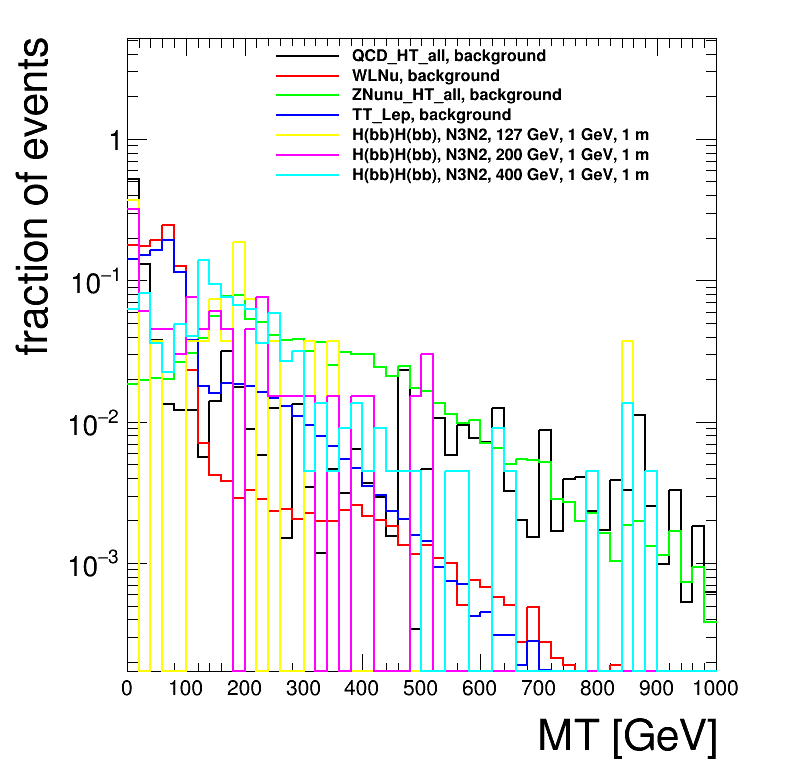

In [53]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_mt[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=trg_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(i+1)
    ht[k].SetMarkerColor(i+1)
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

#     ht[k].Draw('Histsame')
    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(plotDir+'mt_shape.png')
c.SaveAs(plotDir+'mt_shape_allmt.png')

In [236]:
# #sig
# sig_root_dir = uproot.open(signalFileName) 
# sig_tree = sig_root_dir['BDT_Tree']
# # #branches
# sig_w = sig_tree['weight_'].array() 
# sig_jet_pt = sig_tree['jetPt_'].array()
# sig_jet_t = sig_tree['jetTime_'].array()
# sig_jet_nj = np.array([len(x) for x in sig_jet_pt]) 
# print(len(sig_w))
# print(len(sig_jet_pt))
# print(len(sig_jet_t))
# print(sig_jet_nj[:10])
# print(sig_jet_nj[sig_jet_nj>=1][:10])
# print(len(sig_jet_nj[sig_jet_nj>=1]))
# print(np.sum(sig_jet_nj[sig_jet_nj>=1]))
# # print(len(sig_w[sig_nj>=1]))
# print(len(sig_flat_w))
# # from itertools import chain 
# # sig_flat_w = [np.array([x]*len(y)) for x,y in zip(sig_w,sig_jet_pt)]
# # sig_flat_w = list(chain.from_iterable(sig_flat_w))
# # sig_flat_w = [x*137000 for x in sig_flat_w]
# # bkg
# bkg_root_dir = uproot.open(bkgFileName) 
# bkg_tree = bkg_root_dir['BDT_Tree']
# # #branches
# bkg_w = bkg_tree['weight_'].array() 
# bkg_jet_pt = bkg_tree['jetPt_'].array()
# # bkg_flat_w = [np.array([x]*len(y)) for x,y in zip(bkg_w,bkg_jet_pt)]
# # bkg_flat_w = list(chain.from_iterable(bkg_flat_w)) 
# # bkg_flat_w = [x*137000 for x in bkg_flat_w]
# # sample weight
# # sample_w = np.concatenate([sig_flat_w,bkg_flat_w])
# # print(sig_flat_w[0])
# # print(())
# # print(len(sig_flat_w))
# # print(len(sig_w))
# # print(len(sig_jet_pt))
# # print(len(sig_jet_pt.flatten()))


# f = plt.figure()
# ax = f.add_subplot(111)
# plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
# plt.hist(disc_signal_all, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Signal - all")
# plt.hist(disc_bkg_all, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="BKG - all")
# plt.yscale("log")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.001, 1000.0])
# plt.legend(loc="upper right")
# plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
# plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.axvline(x=WP_BKG_threshold, color="black", linestyle='--')
# plt.text(0.5,0.6,'WP_BKG: disc > %.4f'%WP_BKG_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
# plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
# plt.savefig(plotDir+'results/mydiscriminator_' + test_name +'_logY.png')